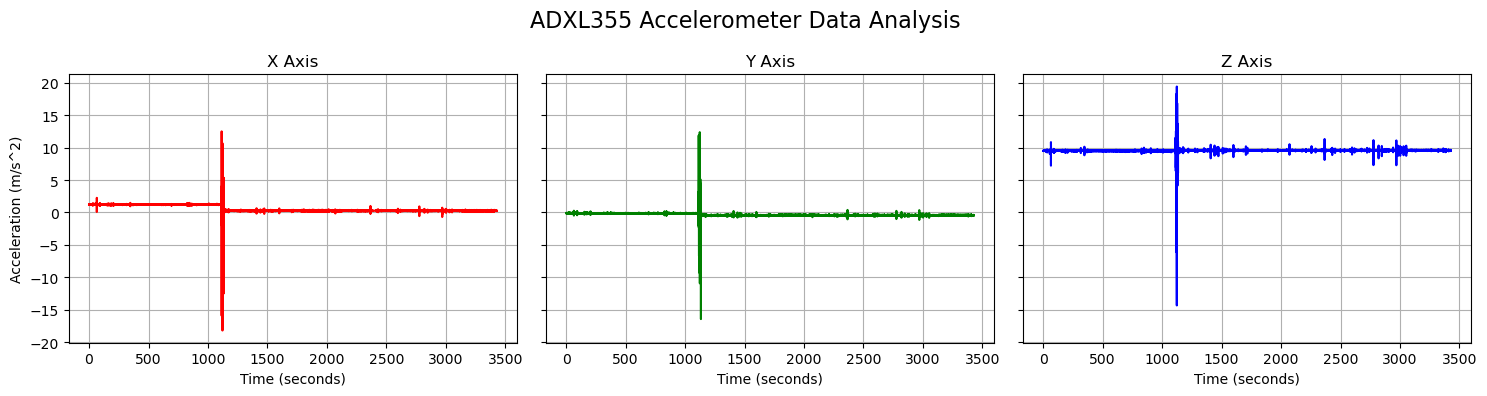

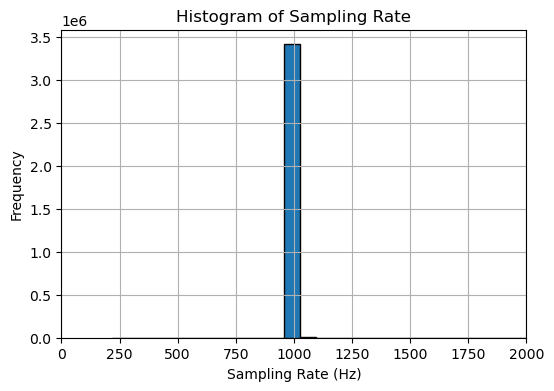


Sampling Rate Statistics:
Mean: 1028.37 Hz
Median: 1000.07 Hz
Std Dev: 1209.86 Hz
Min: 216.31 Hz
Max: 67649.84 Hz

Total number of samples: 3426942
Time span: 0 days 00:57:06.941060304
First timestamp: 2024-07-28 22:01:46.195818663
Last timestamp: 2024-07-28 22:58:53.136878967


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
import re
import struct

def load_and_process_bin_files(folder_path):
    """
    Load and process all .bin files from the specified folder.
    Parameters:
    folder_path (str): Path to the folder containing .bin files.
    Returns:
    pd.DataFrame: DataFrame with processed ADXL355 data.
    """
    all_data = []
    file_pattern = re.compile(r'(\d+\.\d+)_chunk_\d+\.bin')
    
    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith('.bin'):
            match = file_pattern.match(filename)
            if match:
                file_path = os.path.join(folder_path, filename)
                with open(file_path, 'rb') as f:
                    chunk_data = []
                    while True:
                        data = f.read(32)  # 4 doubles, each 8 bytes
                        if not data:
                            break
                        values = struct.unpack('dddd', data)
                        chunk_data.append(values)
                all_data.extend(chunk_data)
    
    if not all_data:
        raise ValueError("No valid .bin files found in the specified folder.")
    
    df = pd.DataFrame(all_data, columns=['Timestamp', 'X (m/s^2)', 'Y (m/s^2)', 'Z (m/s^2)'])
    
    # Convert timestamp to datetime
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
    
    # Set Timestamp as index
    df.set_index('Timestamp', inplace=True)
    
    # Calculate time elapsed in seconds from the start
    start_time = df.index[0]
    df['Time_elapsed'] = (df.index - start_time).total_seconds()
    
    return df

def plot_adxl355_data(df):
    """
    Plot ADXL355 accelerometer data.
    Parameters:
    df (pd.DataFrame): DataFrame with ADXL355 data.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
    fig.suptitle('ADXL355 Accelerometer Data Analysis', fontsize=16)
    
    axes[0].plot(df['Time_elapsed'], df['X (m/s^2)'], 'r-')
    axes[0].set_ylabel('Acceleration (m/s^2)')
    axes[0].set_xlabel('Time (seconds)')
    axes[0].set_title('X Axis')
    axes[0].grid(True)
    
    axes[1].plot(df['Time_elapsed'], df['Y (m/s^2)'], 'g-')
    axes[1].set_xlabel('Time (seconds)')
    axes[1].set_title('Y Axis')
    axes[1].grid(True)
    
    axes[2].plot(df['Time_elapsed'], df['Z (m/s^2)'], 'b-')
    axes[2].set_xlabel('Time (seconds)')
    axes[2].set_title('Z Axis')
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()

def analyze_sampling_rate(df):
    """
    Analyze and plot the sampling rate of ADXL355 data.
    Parameters:
    df (pd.DataFrame): DataFrame with ADXL355 data.
    """
    # Calculate time differences between consecutive samples
    time_diff = df.index.to_series().diff().dt.total_seconds()
    
    # Convert to sampling rate (Hz)
    sampling_rate = 1 / time_diff
    
    # Remove infinite values (from the first row's diff)
    sampling_rate = sampling_rate[np.isfinite(sampling_rate)]
    
    # Plot histogram
    plt.figure(figsize=(6, 4))
    plt.hist(sampling_rate, bins=1000, edgecolor='black')
    plt.title('Histogram of Sampling Rate')
    plt.xlabel('Sampling Rate (Hz)')
    plt.ylabel('Frequency')
    plt.xlim(0, 2000)
    plt.grid(True)
    plt.show()
    
    # Print statistics
    print("\nSampling Rate Statistics:")
    print(f"Mean: {sampling_rate.mean():.2f} Hz")
    print(f"Median: {sampling_rate.median():.2f} Hz")
    print(f"Std Dev: {sampling_rate.std():.2f} Hz")
    print(f"Min: {sampling_rate.min():.2f} Hz")
    print(f"Max: {sampling_rate.max():.2f} Hz")

# Main analysis
folder_path = 'outputs/28-07-2024-18-01-accl-output'  # Research/BVEX/accl_test_jul24/adxl355_dev/outputs/28-07-2024-18-01-accl-output
df = load_and_process_bin_files(folder_path)

# Plot the acceleration data
plot_adxl355_data(df)

# Analyze and plot sampling rate
analyze_sampling_rate(df)

# Print some basic information about the dataset
print(f"\nTotal number of samples: {len(df)}")
print(f"Time span: {df.index[-1] - df.index[0]}")
print(f"First timestamp: {df.index[0]}")
print(f"Last timestamp: {df.index[-1]}")